In [1]:
"""
Figure/data addressing reviewer comments


Reviewer 2:
5. Is there a correlation between codon usage and the encoded Pro tRNA genes in pathogenic bacteria? 
   The authors hint at this in the last sentence of the discussion, but no data is provided. Analysis 
   of representative species (pathogenic vs non-pathogenic) will clarify this and support the statements 
   made about TrmD as a target for antibiotic development.
   
Species to use:
- Escherichia coli         (G -) -> All Pro isoacceptors
- Legionella pneumophila   (G -) -> All Pro isoacceptors
- Acinetobacter baumannii  (G -) -> Pro-UGG only
- Francisella tularensis   (G -) -> Pro-UGG only
- Paenibacillus graminis   (G +) -> All Pro isoacceptors (not pathogen prob)
- Geobacillus kaustophilus (G +) -> All Pro isoacceptors (not pathogen prob)
- Staphylococcus aureus    (G +) -> Pro-TGG only
- Enterococcus faecicalis  (G +) -> Pro-TGG only
- Lactococcus lactis       (G +) -> Pro-TGG and Pro-CGG but no Pro-GGG (not pathogen)


What are some steps to visualize these results?
1) retrieve codon use for each gene in each assembly of interest
2) Plot the normalized (by total Pro codons) Pro codon usage of each gene as a box + whisker plot comparing the included species
3) Hopefully show differences in the use of Pro codons
"""

import pandas as pd
import os
import subprocess
import gzip
import io
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import numpy as np

def readFasta(inFile, idOnly = False):
    seqs = {}
    
    #Handle gzipped fasta files
    if inFile.split('.')[-1] == 'gz':
        with gzip.open(inFile, 'rb') as inF:
            with io.TextIOWrapper(inF, encoding='utf-8') as decoder:
                
                
                for seq in decoder.read().split('>')[1:]:

                    if idOnly == True: #Parse out protein ID for easier indexing
                        if len(seq.split('\n')[0].split('[locus_tag=')) > 1: #Don't grab features without annotated protein ID
                            seqs[seq.split('\n')[0].split('[locus_tag=')[-1].split(']')[0]] = ''.join(seq.split('\n')[1:])
                    else:
                        seqs[seq.split('\n')[0]] = ''.join(seq.split('\n')[1:])
                    inF.close()
                
    else:
        with open(inFile, 'r') as inF:
            for seq in inF.read().split('>')[1:]:
                
                if idOnly == True: #Parse out protein ID for easier indexing
                    if len(seq.split('\n')[0].split('[locus_tag=')) > 1: #Don't grab features without annotated protein ID
                        seqs[seq.split('\n')[0].split('[locus_tag=')[-1].split(']')[0]] = ''.join(seq.split('\n')[1:])
                else:
                    seqs[seq.split('\n')[0]] = ''.join(seq.split('\n')[1:])
                inF.close()
    
    return seqs

def writeFasta(data, fName, blockSize = 60):
    with open(fName, 'w') as f:
        for seq in data.keys():
            f.write('>{0}\n'.format(seq))
            
            s = data[seq]
            for x in range(0, len(s), blockSize):
                f.write(s[x:x+60] + '\n')
                
        f.close()

def retrieveNCBIfile(acc, asm, handle, outFile = False):
    
    if outFile == False:
        outFile = acc
    
    
    rna = {}
    ftpLink = ''
    # download genome sequence
    try:
        ftpLink = 'https://ftp.ncbi.nlm.nih.gov/genomes/all/{1}/{2}/{3}/{4}/{5}_{6}/{5}_{6}_{7}'.format(
                   outFile, acc[:3], acc[4:7], acc[7:10], acc[10:13], acc, asm, handle)

        subprocess.run(['wget', '--quiet', '-O', outFile, ftpLink], check = True)
        
    except subprocess.CalledProcessError:
        
        
        #Update to new accession number
        sacc = acc.split('.')
        version = int(sacc[-1]) + 1
        acs = sacc[:-1] + [str(version)]
        newAcc = '.'.join(acs)
        
        newAsm = ''
        if asm[-2] == 'v':
            sasm = asm.split('v')
            sver = int(sasm[-1]) + 1
            nea = sasm[:-1] + [str(sver)]
            newAsm = 'v'.join(nea)
        else:
            newAsm = asm
        
        ftpLink = 'https://ftp.ncbi.nlm.nih.gov/genomes/all/{1}/{2}/{3}/{4}/{5}_{6}/GO_TO_CURRENT_VERSION/{8}_{9}_{7}'.format(
                   outFile, acc[:3], acc[4:7], acc[7:10], acc[10:13], acc, asm, handle, newAcc, newAsm)

        subprocess.run(['wget', '--quiet', '-O', outFile, ftpLink], check = True)
        
    
    return ftpLink

def countCodons(seq):
    
    codons = {}
    
    for i in range(0, len(seq), 3):
        codon = seq[i:i+3]
        if len(codon) == 3: # <--------------------------- for some reason some genes are shorter than others
            try:
                codons[codon] += 1
            except KeyError:
                codons[codon] = 1
            
    return codons

In [2]:
"""
First, let's select assemblies to use for the analysis
"""

genomes = pd.read_csv('../gtrnadb_info_bact/single_species_gtrnadb_genome_info_bacteria_with_taxonomy.txt', sep = '\t', index_col = 0)

txtList = ['eschColi', 'pseuAeru', 'acinBaum', 'franTula', 'paenGram', 'geobKaus', 'stapAure', 'enteFaec', 'lactLact']
assemblies = []
for i in genomes.index.values:
    if i.split('_')[0] in txtList:
        assemblies.append(i)
 
assemblies = ['acinBaum_1656_2', 'enteFaec_62', 'enteFaec_AUS0004', 'eschColi', 'franTula_HOLARCTICA_425', 'geobKaus_HTA426', 'lactLact_AI06', 'paenGram_DSM15220', 'pseuAeru_19BR', 'stapAure_04_02981']
assms = genomes.loc[assemblies, :]

def countCodons(seq):
    
    codons = {}
    
    for i in range(0, len(seq), 3):
        codon = seq[i:i+3]
        if len(codon) == 3: # <--------------------------- for some reason some genes are shorter than others
            try:
                codons[codon] += 1
            except KeyError:
                codons[codon] = 1
            
    return codons

for g in assms.index.values:
    print(g)
    #Retrieve codon use values
    gbAsm = assms.loc[g, 'Gb_asm_acc']
    rsAsm = assms.loc[g, 'Rs_asm_acc']
    asmName = assms.loc[g, 'Asm_name']
    outF = './select_assemly_cds/{0}-cds_from_genomic.fna.gz'.format(g)
    
    try:
        link = retrieveNCBIfile(rsAsm, asmName, 'cds_from_genomic.fna.gz', outFile = outF)
    except subprocess.CalledProcessError:
        link = retrieveNCBIfile(gbAsm, asmName, 'cds_from_genomic.fna.gz', outFile = outF)
    #Read fasta
    fa = readFasta(outF)
    
    geneData = pd.DataFrame()
    
    
    for i in fa.keys():
        gCodons = pd.DataFrame(countCodons(fa[i]), index = [i])
        
        for c in gCodons.columns.values: #Normalize
            gCodons.loc[i, c] = gCodons.loc[i, c] / sum(gCodons.loc[i, :].tolist())
        
        geneData = pd.concat([gCodons, geneData])
        
    geneData = geneData.fillna(0.0)
    
    outF = './select_assemly_cds/{0}-gene_codon_usage.tsv'.format(g)
    geneData.to_csv(outF, sep = '\t')
    


acinBaum_1656_2
enteFaec_62
enteFaec_AUS0004
eschColi
franTula_HOLARCTICA_425
geobKaus_HTA426
lactLact_AI06
paenGram_DSM15220
pseuAeru_19BR
stapAure_04_02981


{'no1': 0, 'no2': 4, 'yes1': 5, 'yes2': 9}
Gram +
for CCC codon:  KstestResult(statistic=1.0, pvalue=0.007936507936507936)
for CCG codon:  KstestResult(statistic=0.6, pvalue=0.35714285714285715)
for CCA content:  KstestResult(statistic=1.0, pvalue=0.007936507936507936)
for CCU content:  KstestResult(statistic=0.8, pvalue=0.07936507936507936)
for GC content:  KstestResult(statistic=1.0, pvalue=0.007936507936507936)
Gram -
KstestResult(statistic=1.0, pvalue=0.007936507936507936)
for CCC codon:  KstestResult(statistic=1.0, pvalue=0.007936507936507936)
for CCG codon:  KstestResult(statistic=0.8, pvalue=0.07936507936507936)
for CCA content:  KstestResult(statistic=1.0, pvalue=0.007936507936507936)
for CCU content:  KstestResult(statistic=0.8, pvalue=0.07936507936507936)
for GC content:  KstestResult(statistic=0.8, pvalue=0.07936507936507936)


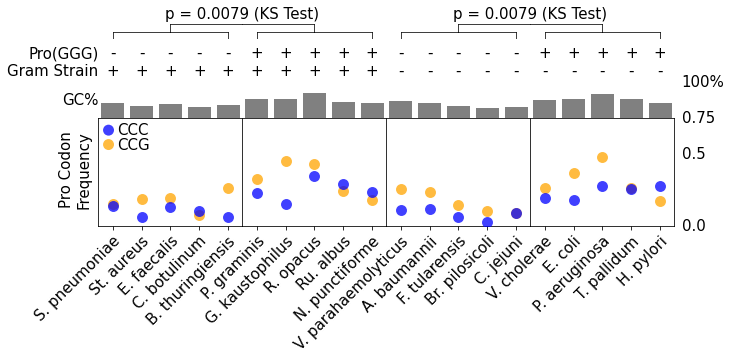

In [7]:
"""
Here is an updated codon useage figure showing just the average (maybe also try with median)
Proline codon use frequency using 10 Gram + and Gram - genomes


"""
import matplotlib.font_manager
plt.rcParams.update({'font.sans-serif':'Arial'})
def drawTreeBottomUp(tree, axes, leafPlacement, leafColors = False, rotation = 'horizontal', addY = 0.1):
    """
    Program to draw tree on specified axes
    """
    
    #Store x and y coordinates of line segments as a positional list for plotting
    xCoords = []
    yCoords = []
    colors = []
    
    nodeCoords = {} # Store coordinates for nodes for later reference
    
    def doStuff(node):
        
        xCo = []
        yCo = []
        cols = []
        
        #Get iterate through child nodes
        for child in node.get_children():
            
            if child.name in nodeCoords.keys(): #If node already exists, and sis already exists
                
                #If node has defined coords, proceed
                coords = nodeCoords[child.name]
                
                xCo.append(coords[0])
                yCo.append(coords[1])
                cols.append('black')
                
            #Handle leaf placement
            elif child.name in leafPlacement.keys():
                nodeCoords[child.name] = (leafPlacement[child.name], 0)
                
                coords = nodeCoords[child.name]
                xCo.append(coords[0])
                yCo.append(coords[1])
                
                
                try:
                    cols.append(leafColors[child.anticodon])
                except AttributeError: #Handle no anticodon attribute specified
                    cols.append('black')
                
            else:
                doStuff(child)
        
        pX = np.mean(xCo)
        pY = max(yCo) + addY
        nodeCoords[node.name] = (pX, pY)
        
        for x, y, c in zip(xCo, yCo, cols):
            
            #Append vertical line
            xCoords.append([x, x])
            yCoords.append([y, pY])
            colors.append(c)
            
            #Append horizontal line
            xCoords.append([x, pX])
            yCoords.append([pY, pY])
            colors.append(c)
        
    #Next, recursively iterate through 
    for n, node in enumerate(tree.traverse("postorder")):
        
        if node.is_leaf() == False: #Skip leaves since laready done
            node.name = n
            doStuff(node)
        
        else:
            pass
    
    #Get coordinates to mediate transformations
    xC = np.array(xCoords)
    yC = np.array(yCoords)
    cC = np.array(colors)
    
    #Transform tree to fit axes
    if rotation == 'horizontal':
        
        #Get x range of coords, then transform to axes range
        xC = xC * (sum(axes.get_xlim())/(np.max(xC) - np.min(xC)))
        yC = yC * (sum(axes.get_ylim())/(np.max(yC) - np.min(yC)))
        
        for x, y, c in zip(xC, yC, cC):
            axes.plot(x, y, color = c, linewidth = 0.75)
            
    
    elif rotation == 'vertical':
        
        #Get x range of coords, then transform to axes range
        xC = xC * (sum(axes.get_ylim())/(np.max(xC) - np.min(xC)))
        yC = (np.max(yC) - yC) * (sum(axes.get_xlim())/(np.max(yC) - np.min(yC)))
        
        for x, y, c in zip(xC, yC, cC):
            axes.plot(y, x, color = c, linewidth = 0.75)







from ete3 import Tree
import scipy.stats as st

spOrder = ['strePneu_670_6B', 'stapAure_04_02981', 'enteFaec_62', 'closBotu_111', 'baciThur_97_27', #No Pro-GGG, G +
           'paenGram_DSM15220', 'geobKaus_HTA426', 'rhodOpac_B4', 'rumiAlbu_7_DSM20455', 'nostPunc_PCC_73102_ATCC29133',#With Pro-GGG, G+
           'vibrPara_BB22OP', 'acinBaum_1656_2', 'franTula_HOLARCTICA_425', 'bracPilo_95_1000', 'campJeju_32488', #No Pro-GGG, G-
           'vibrChol_10432_62', 'eschColi', 'pseuAeru_19BR', 'trepPall_FRIBOURG_BLANC', 'heliPylo_2017'] #With Pro-GGG, G-
spNames = ['S. pneumoniae', 'St. aureus', 'E. faecalis', 'C. botulinum', 'B. thuringiensis',
           'P. graminis', 'G. kaustophilus', 'R. opacus', 'Ru. albus', 'N. punctiforme',
           'V. parahaemolyticus', 'A. baumannii', 'F. tularensis', 'Br. pilosicoli', 'C. jejuni',
           'V. cholerae', 'E. coli', 'P. aeruginosa', 'T. pallidum', 'H. pylori']

gramPos = [ '+', '+','+', '+','+', '+','+', '+','+', '+', '-', '-', '-', '-','-', '-','-', '-','-', '-']
GCcontent = []
ProGGG = ['-', '-', '-', '-', '-', '+', '+', '+', '+','+', '-', '-', '-', '-', '-', '+', '+', '+', '+','+']
spInfo = pd.DataFrame({'gram': gramPos, 'Pro-GGG': ProGGG, 'assembly': spOrder, 'species_names': spNames})
spInfo = spInfo.set_index('assembly', drop = True)
######################################################################################################################
# Retrieve seqeuces

genomes = pd.read_csv('../gtrnadb_info_bact/single_species_gtrnadb_genome_info_bacteria_with_taxonomy.txt', sep = '\t', index_col = 0)

"""genomes['codon_use'] = ''

for x, g in enumerate(spOrder[:]):
    print(g)
    try:
        #Retrieve codon use values
        gbAsm = genomes.loc[g, 'Gb_asm_acc']
        rsAsm = genomes.loc[g, 'Rs_asm_acc']
        asmName = genomes.loc[g, 'Asm_name']
        outF = './select_assemly_cds/{0}-cds_from_genomic.fna.gz'.format(g)

        try:
            link = retrieveNCBIfile(rsAsm, asmName, 'cds_from_genomic.fna.gz', outFile = outF)
        except subprocess.CalledProcessError:
            link = retrieveNCBIfile(gbAsm, asmName, 'cds_from_genomic.fna.gz', outFile = outF)
        #Read fasta
        fa = readFasta(outF)

        geneData = pd.DataFrame()


        for i in fa.keys():
            gCodons = pd.DataFrame(countCodons(fa[i]), index = [i])

            for c in gCodons.columns.values: #Normalize
                gCodons.loc[i, c] = gCodons.loc[i, c] / sum(gCodons.loc[i, :].tolist())

            geneData = pd.concat([gCodons, geneData])

        geneData = geneData.fillna(0.0)

        outF = './select_assemly_cds/{0}-gene_codon_usage.tsv.gz'.format(g)
        geneData.to_csv(outF, sep = '\t', compression = 'gzip')
        genomes.loc[g, 'codon_use'] = os.path.abspath(outF)
    except (ValueError, subprocess.CalledProcessError) as e:
        print('skipped ', g)
"""
#######################################################################################################################

spInfo['gc_content'] = 0
spInfo['avg_ccc_freq'] = 0
spInfo['avg_ccg_freq'] = 0
spInfo['avg_ccu_freq'] = 0
spInfo['avg_cca_freq'] = 0



proCodons =['CCT','CCC', 'CCA', 'CCG']

speciesUse = {}


for g in spOrder:
    # retrieve codon use
    outF = './select_assemly_cds/{0}-gene_codon_usage.tsv.gz'.format(g)
    codons = pd.read_csv(outF, sep = '\t', index_col = 0, compression='gzip')
    
    proTotals = codons.loc[:, proCodons]
    
    proTotals['total'] = [sum(proTotals.loc[x, :]) for x in proTotals.index.values]
    proTotals = proTotals[proTotals['total'] > 0.0] #<-------- Remove genes with no proline codons
    for i in proTotals.columns.values:
        proTotals[i] = proTotals[i]/proTotals['total']
        
    proTotals = proTotals[proCodons]
    proTotals = proTotals.fillna(0)
    
    speciesUse[g] = proTotals
    
    gc= np.array([float(x) for x in genomes.loc[g, 'Seq_GC'].split(' ')])
    chrSize = np.array([float(x) for x in genomes.loc[g, 'Seq_size'].split(' ')])
    
    weightedGC = sum(gc*chrSize)/sum(chrSize)
    
    spInfo.loc[g, 'gc_content'] = weightedGC
    spInfo.loc[g, 'avg_ccc_freq'] = np.mean(proTotals['CCC'])
    spInfo.loc[g, 'avg_ccg_freq'] = np.mean(proTotals['CCG'])
    spInfo.loc[g, 'avg_ccu_freq'] = np.mean(proTotals['CCT'])
    spInfo.loc[g, 'avg_cca_freq'] = np.mean(proTotals['CCA'])
    
    GCcontent.append(round(weightedGC, 1))
    
spInfo['gc_ending_ratio'] = spInfo['avg_ccc_freq']/spInfo['avg_ccg_freq']
spInfo['au_ending_ratio'] = spInfo['avg_ccu_freq']/spInfo['avg_cca_freq']
#Generate figure  

fw = 5.5 * 2
fh = 4 * 2

pw = 1 *2
ph = 0.75 *2

xDisp = 0.75 *2
yDisp = 1.6 *2

plt.figure(figsize =(fw, fh))



#Panel 1: Gram Positive species
for axX, group in enumerate(range(0, len(spInfo.index.values), 5)):
    
    data = spInfo.iloc[group:group + 5, :]
    #data = data.sort_values(['gc_ending_ratio'], ascending = True)
    #yMax = max([np.amax(spInfo['gc_ending_ratio']), np.amax(spInfo['au_ending_ratio'])])
    yMax = 0.75
    ax = plt.axes([(xDisp + axX * 2)/fw, yDisp/fh, pw/fw, ph/fh], xlim = [-0.5, 4.5], 
                  xticks = range(0, 5, 1), ylim = [0, yMax],
                  yticks = [] )
    
    #ax.scatter(range(0, 5, 1), data['gc_ending_ratio'], color = 'black', zorder = 3)
    #ax.scatter(range(0, 5, 1), data['au_ending_ratio'], color = 'black', zorder = 2, alpha = 0.25)
    ax.scatter(range(0, 5, 1), data['avg_ccc_freq'], color = 'blue', zorder = 3, alpha = 0.75, linewidths = 0, s = 120)
    ax.scatter(range(0, 5, 1), data['avg_ccg_freq'], color = 'orange', zorder = 2, alpha = 0.75, linewidths = 0, s = 120)
    #ax.scatter(range(0, 5, 1), data['avg_ccu_freq'], color = 'purple', zorder = 2, alpha = 0.75, linewidths = 0, s = 80)
    #ax.scatter(range(0, 5, 1), data['avg_cca_freq'], color = 'red', zorder = 2, alpha = 0.75, linewidths = 0, s = 80)
    
    #ax.scatter(range(0, 5, 1), data['avg_ccu_freq'], color = 'yellow', zorder = 2, alpha = 0.5)
    #ax.scatter(range(0, 5, 1), data['avg_cca_freq'], color = 'red', zorder = 2, alpha = 0.5)
    #ax.plot([-0.5, 4.5], [1, 1], zorder = 0, color = 'grey', dashes = (3,3,3,3))
    ax.set_xticklabels(data['species_names'], rotation = 45, fontsize = 15, ha = 'right', va = 'top',rotation_mode="anchor")
    
    
    # plot GC content
    GCax = plt.axes([(xDisp + axX*2)/fw, (yDisp + ph+0.005)/fh, pw/fw, 0.5/fh], xlim = [-0.5, 4.5], 
                  xticks = [], ylim = [0, 1],
                  yticks = [] )
    for x, i in enumerate(data['gc_content']):
        
        r = pat.Rectangle([x-0.4, 0], 0.8, i/100, color = 'gray', linewidth = 0)
        GCax.add_patch(r)
    
    for x, gr, pg in zip(range(0, 5, 1), data['gram'], data['Pro-GGG']):
        GCax.text(x, 1.3, gr, ha = 'center', va = 'center', fontsize = 15)
        GCax.text(x, 1.8, pg, ha = 'center', va = 'center', fontsize = 15)
    GCax.axis('off')
    
    if axX == 0:
        GCax.text(-0.5, 1.3, 'Gram Strain', ha = 'right', va = 'center', fontsize = 15)
        GCax.text(-0.5, 1.8, 'Pro(GGG)', ha = 'right', va = 'center', fontsize = 15)
        GCax.text(-0.5, 0.5, 'GC%', ha = 'right', va = 'center', fontsize = 15)
        
        ax.text(-0.75, yMax * 1.05/2, 'Pro Codon\nFrequency', rotation = 90, ha = 'right', va = 'center', fontsize = 15, )
        
        
        ax.scatter([-0.15, -0.15], [yMax - 0.085, yMax - 0.185], 
                   color = ['blue', 'orange'], alpha = 0.75, linewidths = 0, s = 120)
        ax.text(0.15, yMax - 0.085, 'CCC', va = 'center', ha = 'left', fontsize = 15, zorder = 3)
        ax.text(0.15, yMax - 0.185, 'CCG', va = 'center', ha = 'left', fontsize = 15, zorder = 3)
        #ax.text(0.15, yMax - 0.275, 'CCU', va = 'center', ha = 'left', fontsize = 15, zorder = 3)
        #ax.text(0.15, yMax - 0.375, 'CCA', va = 'center', ha = 'left', fontsize = 15, zorder = 3)
        
        
    if axX == 3:
        ax.text(4.75, 0, '0.0', ha = 'left', va = 'center', fontsize = 15)
        ax.text(4.75, 0.75, '0.75', ha = 'left', va = 'center', fontsize = 15)
        ax.text(4.75, 0.5, '0.5', ha = 'left', va = 'center', fontsize = 15)
        #GCax.text(4.75, 0, '0%', ha = 'left', va = 'center', fontsize = 15)
        GCax.text(4.75, 1, '100%', ha = 'left', va = 'center', fontsize = 15)
    
#Draw statsig bars:
tree1 = '((no1, no2),(yes1, yes2));'

t1 = Tree(tree1)
sigAx1 = plt.axes([xDisp/fw, (yDisp + ph + 1.1)/fh, 2*pw/fw, 0.2/fh], xlim = [-0.5, 9.5], ylim = [0, 1])
sigAx1.axis('off')

leafPos1 = {a.name: x for a, x in zip(t1.get_leaves(), [0, 4, 5, 9])}
print(leafPos1)
drawTreeBottomUp(t1, sigAx1, leafPos1)

# compute ks test statistic
woIndex = list(range(0, 5))
wiIndex = list(range(5, 10))
woGGG = spInfo.iloc[woIndex, :]
wiGGG = spInfo.iloc[wiIndex, :]

ks1 =  st.ks_2samp(woGGG['avg_ccc_freq'], wiGGG['avg_ccc_freq'])

sigAx1.text(4.5, 1.2, 'p = ' + str(round(ks1.pvalue, 4)) + ' (KS Test)', ha = 'center', va = 'bottom', fontsize = 15)

print('Gram +')

# compute other ks test statis
print('for CCC codon: ',ks1)
ks1CCG =  st.ks_2samp(woGGG['avg_ccg_freq'], wiGGG['avg_ccg_freq'])
print('for CCG codon: ', ks1CCG)
ks1CCA =  st.ks_2samp(woGGG['avg_cca_freq'], wiGGG['avg_cca_freq'])
print('for CCA content: ', ks1CCA)
ks1CCU =  st.ks_2samp(woGGG['avg_ccu_freq'], wiGGG['avg_ccu_freq'])
print('for CCU content: ', ks1CCU)

ks1GC =  st.ks_2samp(woGGG['gc_content'], wiGGG['gc_content'])
print('for GC content: ', ks1GC)



#################
tree2 = '((no3, no4),(yes3, yes4));'
t2 = Tree(tree2)

sigAx2 = plt.axes([(xDisp + 2 * pw)/fw, (yDisp + ph + 1.1)/fh, 2*pw/fw, 0.2/fh], xlim = [-0.5, 9.5], ylim = [0, 1])
sigAx2.axis('off')

leafPos2 = {a.name: x for a, x in zip(t2.get_leaves(), [0, 4, 5, 9])}
drawTreeBottomUp(t2, sigAx2, leafPos2)

# compute ks test statistic
woIndex = list(range(10, 15))
wiIndex = list(range(15, 20))
woGGG = spInfo.iloc[woIndex, :]
wiGGG = spInfo.iloc[wiIndex, :]

ks2 =  st.ks_2samp(woGGG['avg_ccc_freq'], wiGGG['avg_ccc_freq'])

sigAx2.text(4.5, 1.2, 'p = ' + str(round(ks2.pvalue, 4)) + ' (KS Test)', ha = 'center', va = 'bottom', fontsize = 15)

plt.savefig('codon_use_dist_select_species_v3.png', dpi = 1000)


print('Gram -')
print(ks2)


# compute other ks test stats
print('for CCC codon: ',ks2)
ks2CCG =  st.ks_2samp(woGGG['avg_ccg_freq'], wiGGG['avg_ccg_freq'])
print('for CCG codon: ', ks2CCG)
ks2CCA =  st.ks_2samp(woGGG['avg_cca_freq'], wiGGG['avg_cca_freq'])
print('for CCA content: ', ks2CCA)
ks2CCU =  st.ks_2samp(woGGG['avg_ccu_freq'], wiGGG['avg_ccu_freq'])
print('for CCU content: ', ks2CCU)

ks2GC =  st.ks_2samp(woGGG['gc_content'], wiGGG['gc_content'])
print('for GC content: ', ks2GC)

